# 코퍼스 : 문서의 집합 (분석 대상)
문서1) 저는 사과 좋아요   
문서2) 저는 바나나 좋아요  
문서3) 저는 바나나 좋아요 저는 바나나 좋아요  

딸기 -> out of vocab :oov


In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from numpy import dot
# dot : 두벡터의 내적
# norm : 벡터의 크기



In [3]:
doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])


In [4]:
dot(doc1, doc2) # 두벡터의 내적
norm(doc1)

1.7320508075688772

# 코사인 유사도 구하기

In [5]:
import pandas as pd 
data = pd.read_csv("C:/Python37_Project/bundle_archive/movies_metadata.csv")
# data.head() 
# data.info()
data=data.head(20000)
data['overview'].isnull().sum()
data['overview']=data['overview'].fillna('')
data['overview'].isnull().sum()

0

In [6]:
from sklearn.feature_extraction.text import  TfidfVectorizer

In [7]:
Tfidf=TfidfVectorizer(stop_words='english')
TfidfMatrix = Tfidf.fit_transform(data['overview'])

In [8]:
TfidfMatrix.shape

(20000, 47487)

In [9]:
from sklearn.metrics.pairwise import linear_kernel

# 코사인 유사도 구하기

In [10]:
cos_sim = linear_kernel(TfidfMatrix, TfidfMatrix)

In [11]:
cos_sim.shape

(20000, 20000)

toy stroy 영화제목을 입력 
영화제목에 해당하는 코사인 유사도 확인

In [12]:
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [13]:
# 중복확인하기
data['title'].duplicated().sum()

indices = pd.Series(data.index, index = data['title']).drop_duplicates() # 인덱스를 가지고 시리즈 만들기! -> 인덱스가 데이터가 됨.

In [14]:
indices.head()
indices['Batman']

Batman     585
Batman    8603
dtype: int64

In [15]:
def getRecommendation(title, cosine_sim = cos_sim ):
    # 타이틀에 저장된 영화 제목으로 코사인 유사도가 높은 10편의 영화를 추출
    idx = indices[title]
    simScores = list(enumerate(cosine_sim[idx]))
    # simScores의 유사도 값을 기준으로 내림차순 정렬
    simScores = sorted(simScores, key= lambda x:x[1], reverse=True)
    simScores = simScores[1:21]
    movieidx = [i[0] for i in simScores]
    return data['title'].iloc[movieidx]

In [16]:
getRecommendation('Toy Story')

15348                                    Toy Story 3
2997                                     Toy Story 2
10301                         The 40 Year Old Virgin
8327                                       The Champ
1071                           Rebel Without a Cause
11399                         For Your Consideration
1932                                       Condorman
3057                                 Man on the Moon
485                                           Malice
11606                                   Factory Girl
17189                                      Group Sex
7254                                  Africa Screams
5797                                   Class of 1984
13947                            The Gang's All Here
1032                                   The Sunchaser
3252                                 Bound for Glory
2157                               Indecent Proposal
7615     The First $20 Million Is Always the Hardest
6944                                Rivers and

# CNN 기반으로 분류

# 영화 리뷰 분류(이진 분류)

In [17]:
from keras.datasets import imdb

In [18]:
(traindata, trainlabel), (testdata, testlabel) = imdb.load_data(num_words=10000)
#자주 사용되는 단어 10000개만 추려서 사용


In [19]:
trainlabel.shape # 0 : 부정, 1: 긍정


(25000,)

In [20]:
maxseq = [max(seq) for seq in traindata]
max(maxseq) # 가장 큰 값을 출력했움!


9999

In [21]:
word_index = imdb.get_word_index() # 자료구조는 딕셔너리
len(word_index)


88584

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [23]:
print(reverse_word_index.get(1000000, "?"))
# 만약 인덱스가 1000000이 존재하지 않으면 ?으로 대체하라 
# 0,1,2는 '패딩' ' 문서시작' '사전에 없음을 인덱스로 약속되어 사용됨 따라서 위 3개를 제외 위 3개는 물음표문자로 대체

decodedReviews = " ".join(reverse_word_index.get(i-3, '?')for i in traindata[0])

?


In [24]:
decodedReviews

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

""" 
패딩 : 문장의 길이가 다름 -> 문장의 길이를 동일하게 해줌 
신경망 모델을 만들기 위해서는 먼저 패딩을 수행하여 모든 문장모든 문장의 길이를 동일하게 해줘야 함.  
"""


In [25]:
sentences = [['barber', 'person'], ['barber', 'good', 'person'], ['barber', 'huge', 'person'], ['knew', 'secret'], ['secret', 'kept', 'huge', 'secret'], ['huge', 'secret'], ['barber', 'kept', 'word'], ['barber', 'kept', 'word'], ['barber', 'kept', 'secret'], ['keeping', 'keeping', 'huge', 'secret', 'driving', 'barber', 'crazy'], ['barber', 'went', 'huge', 'mountain']]

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [27]:
tok = Tokenizer()
tok.fit_on_texts(sentences) # 빈도수를 기준으로 단어 집합 생성


In [28]:
tok.word_counts # 단어들의 빈도 수를 알려줌 

OrderedDict([('barber', 8),
             ('person', 3),
             ('good', 1),
             ('huge', 5),
             ('knew', 1),
             ('secret', 6),
             ('kept', 4),
             ('word', 2),
             ('keeping', 2),
             ('driving', 1),
             ('crazy', 1),
             ('went', 1),
             ('mountain', 1)])

In [29]:
tok.word_index # 이것을 기초로 단어를 숫자로 만들 수 있음 



{'barber': 1,
 'secret': 2,
 'huge': 3,
 'kept': 4,
 'person': 5,
 'word': 6,
 'keeping': 7,
 'good': 8,
 'knew': 9,
 'driving': 10,
 'crazy': 11,
 'went': 12,
 'mountain': 13}

In [30]:
encoded = tok.texts_to_sequences(sentences)
encoded

maxLen = max(len(item) for item in encoded)

In [31]:
for item in encoded:
    while len(item) < maxLen:
        item.append(0)

padded_np = np.array(encoded)
padded_np

array([[ 1,  5,  0,  0,  0,  0,  0],
       [ 1,  8,  5,  0,  0,  0,  0],
       [ 1,  3,  5,  0,  0,  0,  0],
       [ 9,  2,  0,  0,  0,  0,  0],
       [ 2,  4,  3,  2,  0,  0,  0],
       [ 3,  2,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  2,  0,  0,  0,  0],
       [ 7,  7,  3,  2, 10,  1, 11],
       [ 1, 12,  3, 13,  0,  0,  0]])

# 케라스에서 제로 패딩

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
encoded = tok.texts_to_sequences(sentences)
padded = pad_sequences(encoded, padding = 'post')
padded

array([[ 1,  5,  0,  0,  0,  0,  0],
       [ 1,  8,  5,  0,  0,  0,  0],
       [ 1,  3,  5,  0,  0,  0,  0],
       [ 9,  2,  0,  0,  0,  0,  0],
       [ 2,  4,  3,  2,  0,  0,  0],
       [ 3,  2,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  2,  0,  0,  0,  0],
       [ 7,  7,  3,  2, 10,  1, 11],
       [ 1, 12,  3, 13,  0,  0,  0]])

In [34]:
def vectorize_sequences(sequences, dimension = 10000):
    result = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        # print(i, "번 리뷰:",seq)
        result[i, seq]= 1
    return result
xtrain = vectorize_sequences(traindata)
xtest = vectorize_sequences(testdata)


In [35]:
ytrain = np.array(trainlabel).astype('float32')
ytrain
ytest = np.array(trainlabel).astype('float32')
ytest

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [36]:
from keras import models, layers

In [37]:
model=models.Sequential()
# 입력 계층을 추가해보자
model.add(layers.Dense(16, activation='relu',input_shape=(10000,))) 
# layer(층)을 추가. =모델에다가 계층 1개를 추가해라.
# 히든 계층을 추가해보자
model.add(layers.Dense(16, activation='relu')) 
# 출력 계층을 추가해보자
model.add(layers.Dense(1, activation='sigmoid')) # 마지막은 sigmoid


In [38]:
model.compile(optimizer='rmsprop', loss ='binary_crossentropy', metrics= ["accuracy"])

In [39]:
xval = xtrain[:10000]
pxtrain = xtrain[10000:]
yval = ytrain[:10000]
pytrain = ytrain[10000:]

In [42]:
history = model.fit(pxtrain, pytrain, 
                    epochs=30, batch_size=256, validation_data=(xval, yval))
history

Epoch 1/30
59/59 [==============================] - 1s 18ms/step - loss: 1.8515e-04 - accuracy: 1.0000 - val_loss: 1.0507 - val_accuracy: 0.8628
Epoch 2/30
59/59 [==============================] - 1s 13ms/step - loss: 4.6124e-04 - accuracy: 0.9999 - val_loss: 1.0947 - val_accuracy: 0.8622
Epoch 3/30
59/59 [==============================] - 1s 14ms/step - loss: 8.1783e-05 - accuracy: 1.0000 - val_loss: 1.1536 - val_accuracy: 0.8587
Epoch 4/30
59/59 [==============================] - 1s 20ms/step - loss: 1.6625e-04 - accuracy: 0.9999 - val_loss: 1.2170 - val_accuracy: 0.8606
Epoch 5/30
59/59 [==============================] - 1s 12ms/step - loss: 3.5720e-05 - accuracy: 1.0000 - val_loss: 1.2915 - val_accuracy: 0.8604
Epoch 6/30
59/59 [==============================] - 1s 13ms/step - loss: 2.4163e-04 - accuracy: 0.9999 - val_loss: 1.4005 - val_accuracy: 0.8600
Epoch 7/30
59/59 [==============================] - 1s 13ms/step - loss: 1.0558e-05 - accuracy: 1.0000 - val_loss: 1.4286 - val_ac

In [44]:
histDict = history.history
histDict.keys()
history.history['accuracy']

[1.0,
 0.9998666644096375,
 1.0,
 0.9999333620071411,
 1.0,
 0.9999333620071411,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999333620071411,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

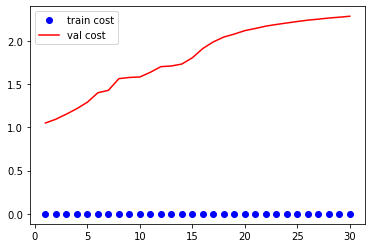

In [48]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['loss'],'bo', label = 'train cost')
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['val_loss'],'r', label = 'val cost')

plt.legend()

In [49]:
history = model.fit(xtrain, ytrain, 
                    epochs=4, batch_size=512)
history

Epoch 1/4
49/49 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.9449/49 [==============================] - 1s 11ms/step - loss: 0.6285 - accuracy: 0.9413
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2653 - accuracy: 0.9506
Epoch 3/4
49/49 [==============================] - 1s 15ms/step - loss: 0.1793 - accuracy: 0.9610
Epoch 4/4
49/49 [==============================] - 1s 14ms/step - loss: 0.1278 - accuracy: 0.9693


In [50]:
res = model.evaluate(xtest, ytest)
res

782/782 [==============================] - 1s 2ms/step - loss: 6.2525 - accuracy: 0.5006


[6.252484321594238, 0.5005599856376648]

In [51]:
model.predict(xtest)

array([[4.5189261e-04],
       [1.0000000e+00],
       [9.9992764e-01],
       ...,
       [1.6583830e-02],
       [3.9990336e-02],
       [9.4925034e-01]], dtype=float32)